# Finetuning pre-trained in a self-supervised manner ViT transformer on the LIDC dataset.
Idea is to evaluate how training data will influence End2End DINO based classifier. There are three training approaches:
* **Vanilla** - model is trained only on the middle slice of a nodule in three views.
* **Greedy** - from each nodule I extract 15 middle slices for each view. 45 times more training slices! :D
* **3DViT** - model is trained on volume extracted from each nodule in three views. One nodule = 3 volumes.

Finally, models are evaluated on the validation and test set. Each nodule in those sets is treated in 3 views. Evaluation is only performed on the middle slice (Vanilla, Greedy) and middle slice with a context of few adjacent slices (3DViT).

In [1]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import torch
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
from typing import Literal
import os

In [2]:
%load_ext autoreload
%autoreload 2
    
from my_utils.plot_utils import plot_hists
from my_utils.norm_factors import compute_norm_factors

### Dividing dataset into three sets: training, validation and test sets.

In [3]:
# Paths
local = True
if local:
    data_path = "/home/jbinda/INFORM/LIDC/dataset/"
else:
    data_path = "/home/dzban112/LIDC/dataset/"

In [4]:
#Reading all annotations and extracting paths, target: benign, malignant.
df = pd.read_pickle(f"{data_path}/ALL_annotations_df.pkl")
paths = df["path"]
targets_concepts = df[["target","subtlety", "calcification", "margin", "lobulation", 
                         "spiculation", "diameter", "texture", "sphericity"]].copy()

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(paths, targets_concepts, 
                                                            test_size=0.15, random_state=44, 
                                                            shuffle=True, stratify=targets_concepts["target"])

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                            test_size=0.15, random_state=44, 
                                                            shuffle=True, stratify=y_train_val["target"])

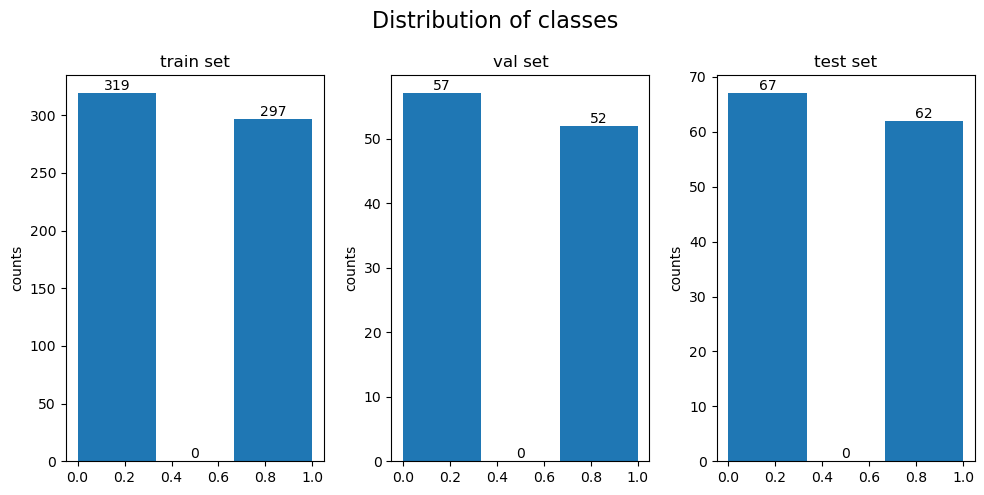

In [7]:
plot_hists(y_train, y_val,  y_test)

## Preparing sets for the Vanilla model:
For the Vanilla model, both for training and val/test, from each nodule I extract middle slice in three views.

In [8]:
Path("Vanilla/data/crops/train").mkdir(parents=True, exist_ok=True)
Path("Vanilla/data/crops/val").mkdir(parents=True, exist_ok=True)
Path("Vanilla/data/crops/test").mkdir(parents=True, exist_ok=True)


def create_vanilla_sets(X, Y, mode: Literal["train", "val", "test"]="train", savepath="Vanilla/data/"):
    df_rows = []
    columns=['target', 'subtlety', 'calcification', 'margin', 'lobulation',
             'spiculation', 'diameter', 'texture', 'sphericity']
    new_id = 1 # new id
    for i, nodule in enumerate(X):
        slice_=15 # I set up 15th slice as a middle one. 
        crop = torch.load(data_path+f"/crops/"+nodule)
        for view in ["axial"]: #["axial", "coronal", "sagittal"]
            if view == "axial":
                img = crop[:, :, slice_]
            elif view == "coronal":
                img = crop[:, slice_, :]
            elif view == "sagittal":
                img = crop[slice_, :, :]
            img = torch.clamp(img, -1000, 400)
            img = img.unsqueeze(0)
            img = img.repeat(3,1,1)
            str_new_id = str(new_id).zfill(4)
            torch.save(img.clone().float(), savepath+f"crops/{mode}/"+str_new_id+".pt")
            row = list(Y.iloc[i])
            df_rows.append(row)
            new_id+=1
    new_df = pd.DataFrame(df_rows, columns=columns)
    with open(savepath+f"y_{mode}_df.pkl", "wb") as file:
        pickle.dump(new_df, file)
    return new_df

In [9]:
y_train_df = create_vanilla_sets(X_train, y_train, mode="train")
y_val_df = create_vanilla_sets(X_val, y_val, mode="val")
y_test_df = create_vanilla_sets(X_test, y_test, mode="test")

In [10]:
print(f"There is {len(y_train_df)} training examples!")
print(f"There is {len(y_val_df)} validational examples!")
print(f"There is {len(y_test_df)} test examples!")

There is 616 training examples!
There is 109 validational examples!
There is 129 test examples!


In [11]:
y_train_df.head()

,target,subtlety,calcification,margin,lobulation,spiculation,diameter,texture,sphericity
0,0.0,4.750000,3.750000,4.750000,1.250000,1.250000,9.563974,5.000000,4.500000
1,0.0,3.666667,5.333333,4.000000,1.666667,1.666667,6.950641,5.000000,4.000000
2,1.0,5.000000,6.000000,3.000000,2.750000,2.500000,38.389619,3.500000,3.000000
3,0.0,3.000000,6.000000,3.666667,1.000000,1.000000,7.505375,2.666667,3.333333
4,0.0,4.000000,4.500000,4.250000,3.000000,1.250000,10.479321,5.000000,2.500000


### Computing normalization factors

In [12]:
def compute_norm_factors():
    train_slices_path="Vanilla/data/crops/train/"
    slices = os.listdir(train_slices_path)
    imgs_stack = []
    for slice_ in slices:
        img = torch.load(train_slices_path+slice_)
        imgs_stack.append(img)
    imgs_stack = torch.stack(imgs_stack, axis=0)
    channels_mean = torch.mean(imgs_stack)
    channels_std = torch.std(imgs_stack)
    return [channels_mean, channels_std]

In [13]:
mean, std = compute_norm_factors()
print(f"MEAN: {mean}")
print(f"STD: {std}")

MEAN: -627.5725708007812
STD: 363.660888671875


In [14]:
with open("Vanilla/data/vanilla_norm_fact.pkl", "wb") as f:
    pickle.dump({"MEAN":mean, "STD":std}, f)

### Exemplary slice

In [15]:
import matplotlib.pyplot as plt

In [16]:
img = torch.load("Vanilla/data/crops/train/0030.pt")

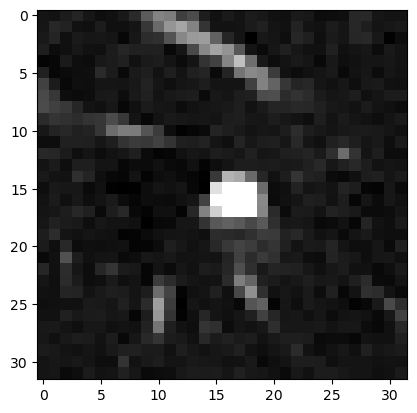

In [17]:
plt.imshow(img.cpu().numpy()[0], cmap='gray')

## Preparing datasets for the Greedy model:
For training the Greedy model, from each nodule I extract k*2 slices in three views. For val/test I extract only central slice in three views.

In [20]:
Path(f"Greedy/data/crops/train").mkdir(parents=True, exist_ok=True)
Path(f"Greedy/data/crops/val").mkdir(parents=True, exist_ok=True)
Path(f"Greedy/data/crops/test").mkdir(parents=True, exist_ok=True)


def create_greedy_sets(X, Y, k=5, mode: Literal["train", "val", "test"]="train", savepath="Greedy/data/"):
    df_rows = []
    columns=['target', 'subtlety', 'calcification', 'margin', 'lobulation',
             'spiculation', 'diameter', 'texture', 'sphericity']
    new_id = 1 # new id
    for i, nodule in enumerate(X):
        crop = torch.load(data_path+"/crops/"+nodule)
        for slice_ in range(15-k, 15+k) if mode=="train" else [15]:
            for view in ["axial", "coronal", "sagittal"]:
                if view == "axial":
                    img = crop[:, :, slice_]
                elif view == "coronal":
                    img = crop[:, slice_, :]
                elif view == "sagittal":
                    img = crop[slice_, :, :]
                img = torch.clamp(img, -1000, 400)
                img = img.unsqueeze(0)
                img = img.repeat(3,1,1)
                str_new_id = str(new_id).zfill(5)
                torch.save(img.clone().float(), savepath+f"crops/{mode}/"+str_new_id+".pt")
                row = list(Y.iloc[i])
                df_rows.append(row)
                new_id+=1
    new_df = pd.DataFrame(df_rows, columns=columns)
    with open(savepath+f"y_{mode}_df.pkl", "wb") as file:
        pickle.dump(new_df, file)
    return new_df

In [21]:
y_train_df = create_greedy_sets(X_train, y_train, k=5, mode="train")
y_val_df = create_greedy_sets(X_val, y_val, k=5, mode="val")
y_test_df = create_greedy_sets(X_test, y_test, k=5, mode="test")

In [22]:
print(f"There is {len(y_train_df)} examples!")
print(f"There is {len(y_val_df)} examples!")
print(f"There is {len(y_test_df)} examples!")

There is 18480 examples!
There is 327 examples!
There is 387 examples!


In [23]:
y_train_df.head()

,target,subtlety,calcification,margin,lobulation,spiculation,diameter,texture,sphericity
0,0.0,4.75,3.75,4.75,1.25,1.25,9.563974,5.0,4.5
1,0.0,4.75,3.75,4.75,1.25,1.25,9.563974,5.0,4.5
2,0.0,4.75,3.75,4.75,1.25,1.25,9.563974,5.0,4.5
3,0.0,4.75,3.75,4.75,1.25,1.25,9.563974,5.0,4.5
4,0.0,4.75,3.75,4.75,1.25,1.25,9.563974,5.0,4.5


### Computing normalization factors

In [24]:
def compute_norm_factors():
    train_slices_path="Greedy/data/crops/train/"
    slices = os.listdir(train_slices_path)
    imgs_stack = []
    for slice_ in slices:
        img = torch.load(train_slices_path+slice_)
        imgs_stack.append(img)
    imgs_stack = torch.stack(imgs_stack, axis=0)
    channels_mean = torch.mean(imgs_stack)
    channels_std = torch.std(imgs_stack)
    return [channels_mean, channels_std]

In [25]:
mean, std = compute_norm_factors()
print(f"MEAN: {mean}")
print(f"STD: {std}")

MEAN: -637.7864990234375
STD: 356.4347229003906


In [26]:
with open("Greedy/data/greedy_norm_fact.pkl", "wb") as f:
    pickle.dump({"MEAN":mean, "STD":std}, f)